## XGBoost Regression for Spine Moments

The primary goal with this notebook is to re-create the Linear Regression model using the AWS SageMaker platform.

## Imports

In [29]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
import seaborn as sns

from sklearn import svm, preprocessing, metrics, linear_model

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.amazon import amazon_estimator

## Download and parse dataset

In [2]:
def download_dataset(s3_uri):
    bucket, path = sagemaker.s3.parse_s3_url(s3_uri)
    local_path = Path(path)
    if not local_path.exists():
        sagemaker.s3.S3Downloader.download(s3_uri, local_path.parent)
    return local_path

def load_dataset(file_name):
    df = pd.read_csv(file_name)
    df = df.dropna()
    #df = df.set_index(['Trial_Name', 'Trial_Index']);
    #df.sort_index(
    #    level=['Trial_Name','Trial_Index'], 
    #    ascending=[True, True], inplace=True)
    return df

local_dataset = download_dataset("s3://cpac/ORIG/S1_lumbar_results.csv")
print(f"Local dataset: {local_dataset} [{local_dataset.stat().st_size} bytes]")
df = load_dataset(local_dataset)

Local dataset: ORIG/S1_lumbar_results.csv [236614139 bytes]


## Understand the dataset format

In [3]:
print("Number of samples:" ,df.shape[0])
print("Number of trials:", len(df["Trial_Name"].unique()))

features = df.loc[:, "GRF_LeftFoot":].columns.to_list()
print("Number of features:", len(features))
print("Features:", ", ".join(features))

targets = [
           "Pelvis_Moment_X", 
           "Pelvis_Moment_Y", 
           "Pelvis_Moment_Z", 
           "single_equiv_force", 
           "poly_force"]
print("Number of targets:", len(targets))
print("Targets:", ", ".join(targets))

Number of samples: 257887
Number of trials: 309
Number of features: 30
Features: GRF_LeftFoot, GRF_RightFoot, LEFT_COP_Y, LEFT_COP_X, RIGHT_COP_Y, RIGHT_COP_X, LEFT_FOOT_ANGLE_X, LEFT_FOOT_ANGLE_Y, LEFT_FOOT_ANGLE_Z, RIGHT_FOOT_ANGLE_X, RIGHT_FOOT_ANGLE_Y, RIGHT_FOOT_ANGLE_Z, LEFT_SHANK_ANGLE_X, LEFT_SHANK_ANGLE_Y, LEFT_SHANK_ANGLE_Z, RIGHT_SHANK_ANGLE_X, RIGHT_SHANK_ANGLE_Y, RIGHT_SHANK_ANGLE_Z, LEFT_THIGH_ANGLE_X, LEFT_THIGH_ANGLE_Y, LEFT_THIGH_ANGLE_Z, RIGHT_THIGH_ANGLE_X, RIGHT_THIGH_ANGLE_Y, RIGHT_THIGH_ANGLE_Z, PELVIS_ANGLE_X, PELVIS_ANGLE_Y, PELVIS_ANGLE_Z, TRUNK_ANGLE_X, TRUNK_ANGLE_Y, TRUNK_ANGLE_Z
Number of targets: 5
Targets: Pelvis_Moment_X, Pelvis_Moment_Y, Pelvis_Moment_Z, single_equiv_force, poly_force


## Test / train split

We are also selecting the target variable and the (sub)set of features.

In [4]:
def train_test_split(df, features, target, test_trial, n_train=-1):
    
    # test/train selection
    test_select = (df["Trial_Name"] == test_trial)
    df_train = df[~test_select]
    df_test = df[test_select]

    # downselect - too much data for SVM
    if n_train > 0:
        df_train = df_train.sample(n = n_train)

    # normalization
    norm = preprocessing.StandardScaler()
    X_train = norm.fit_transform(df_train[features])
    X_test = norm.transform(df_test[features])

    # select target variable
    return (
        X_train, X_test, 
        df_train[target], df_test[target])
    
TEST_TRIAL = "ESM_raisedstoop_5kg_01"
TARGET = targets[0]
FEATURES = features[:]

X_train, X_test, y_train, y_test = train_test_split(
    df, FEATURES, TARGET, TEST_TRIAL)

print(
    "Shapes X_train: %s, X_test: %s, y_train: %s, y_test: %s" %
    (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Shapes X_train: (256585, 30), X_test: (1302, 30), y_train: (256585,), y_test: (1302,)


## Convert and upload the data for training

We are using the recordIO-wrapped protobuf format.

In [6]:
def upload_tensor(s3_uri, X, y):
    bucket, path = sagemaker.s3.parse_s3_url(s3_uri)
    local_path = Path(path)
    local_path.parent.mkdir(parents=True, exist_ok=True)
    yX = np.concatenate((y.values[:, np.newaxis], X), axis=1)
    np.savetxt(local_path, yX, delimiter=",")
    sagemaker.s3.S3Uploader.upload(str(local_path), s3_uri)
    return local_path

s3_train_data = "s3://cpac/SM/S1_lumbar_results/train.csv"
upload_tensor(s3_train_data, X_train, y_train)
print('Uploaded training data to: {}'.format(s3_train_data))

s3_test_data = "s3://cpac/SM/S1_lumbar_results/test.csv"
upload_tensor(s3_test_data, X_test, y_test)
print('Uploaded test data to: {}'.format(s3_test_data))

Uploaded training data to: s3://cpac/SM/S1_lumbar_results/train.csv
Uploaded test data to: s3://cpac/SM/S1_lumbar_results/test.csv


## Training

In [16]:
sess = sagemaker.Session()
region = sess.boto_session.region_name
role = sagemaker.get_execution_role()


container = amazon_estimator.get_image_uri(region, 'xgboost')
s3_input_train = sagemaker.s3_input(s3_data="s3://cpac/SM/S1_lumbar_results/train.csv", content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data="s3://cpac/SM/S1_lumbar_results/test.csv", content_type='csv')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type="ml.m4.xlarge",
                                    output_path="s3://cpac/SM/S1_lumbar_results/output",
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective="reg:linear",
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_test}) 

	get_image_uri(region, 'xgboost', '0.90-1').


2020-01-14 20:28:29 Starting - Starting the training job...
2020-01-14 20:28:30 Starting - Launching requested ML instances......
2020-01-14 20:29:32 Starting - Preparing the instances for training......
2020-01-14 20:30:59 Downloading - Downloading input data
2020-01-14 20:30:59 Training - Downloading the training image...
2020-01-14 20:31:18 Training - Training image download completed. Training in progress.Arguments: train
[2020-01-14:20:31:19:INFO] Running standalone xgboost training.
[2020-01-14:20:31:19:INFO] File size need to be processed in the node: 194.55mb. Available memory size in the node: 8496.13mb
[2020-01-14:20:31:19:INFO] Determined delimiter of CSV input is ','
[20:31:19] S3DistributionType set as FullyReplicated
[20:31:20] 256585x30 matrix with 7697550 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-01-14:20:31:20:INFO] Determined delimiter of CSV input is ','
[20:31:20] S3DistributionType set as FullyReplicated
[20:31:20] 130

[20:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[56]#011train-rmse:10.613#011validation-rmse:6.0345
[20:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[57]#011train-rmse:10.6036#011validation-rmse:6.02768
[20:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[58]#011train-rmse:10.5727#011validation-rmse:6.06031
[20:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[59]#011train-rmse:10.5547#011validation-rmse:6.06156
[20:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[60]#011train-rmse:10.5179#011validation-rmse:6.06295
[20:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[61]#011train-rmse:10.4851#011validation-rmse:6.06236
[20:31

Training seconds: 94
Billable seconds: 94


## Prediction

In [17]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = "ml.m4.xlarge")

-------------------------------------------------------------------------------------------------------------------!

In [18]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = sagemaker.predictor.csv_serializer
xgb_predictor.deserializer = None
result = xgb_predictor.predict(X_test).decode('utf-8')
y_pred = np.array([float(v) for v in result.split(",")])

## Delete the Endpoint
If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [13]:
sess.delete_endpoint(xgb_predictor.endpoint)

## Show results

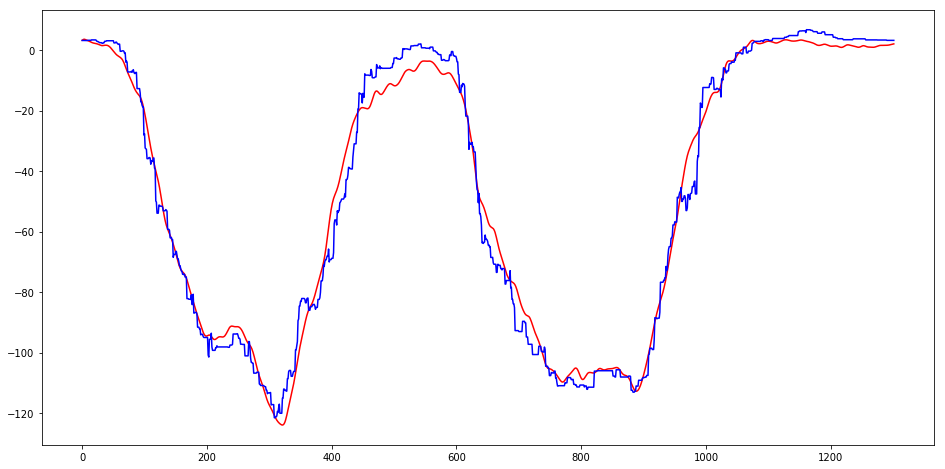

In [20]:
plt.plot(y_test.values, 'r')
plt.plot(y_pred, 'b')

## Hyperparameter Tunig

In [27]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic")
}

tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name="validation:rmse",
    objective_type="Minimize",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=10,
    strategy='Random'
)

tuner_log.fit({'train': s3_input_train, 'validation': s3_input_test}, include_cls_metadata=False)

## Analyse Tuning Results

In [35]:
# check jobs have finished
status_log = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

assert status_log == 'Completed', "Tuning must be completed, was {}".format(status_log)

df_log = sagemaker.HyperparameterTuningJobAnalytics(tuner_log.latest_tuning_job.job_name).dataframe()
df_log['scaling'] = 'log'
df_log

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,lambda,scaling
0,5.31175,116.0,2020-01-14 21:02:06+00:00,xgboost-200114-2052-020-b0840846,Completed,2020-01-14 21:00:10+00:00,0.282803,0.235827,log
1,4.92897,138.0,2020-01-14 21:01:58+00:00,xgboost-200114-2052-019-fcbcb347,Completed,2020-01-14 20:59:40+00:00,0.692986,0.035996,log
2,4.90841,98.0,2020-01-14 21:01:20+00:00,xgboost-200114-2052-018-78cd3f49,Completed,2020-01-14 20:59:42+00:00,0.073149,0.033062,log
3,5.51056,111.0,2020-01-14 21:01:32+00:00,xgboost-200114-2052-017-23fc49b1,Completed,2020-01-14 20:59:41+00:00,0.313338,0.512292,log
4,5.48925,99.0,2020-01-14 21:01:20+00:00,xgboost-200114-2052-016-6efcfed2,Completed,2020-01-14 20:59:41+00:00,0.023641,0.489896,log
5,5.15018,114.0,2020-01-14 21:01:33+00:00,xgboost-200114-2052-015-4910f067,Completed,2020-01-14 20:59:39+00:00,0.029128,0.248943,log
6,5.28870,110.0,2020-01-14 21:01:30+00:00,xgboost-200114-2052-014-2347552d,Completed,2020-01-14 20:59:40+00:00,0.010418,8.080971,log
7,5.97693,97.0,2020-01-14 21:00:59+00:00,xgboost-200114-2052-013-0bb8f0c9,Completed,2020-01-14 20:59:22+00:00,0.309232,1.350890,log
8,5.04601,102.0,2020-01-14 21:01:02+00:00,xgboost-200114-2052-012-cfd9fbd7,Completed,2020-01-14 20:59:20+00:00,0.143704,0.149435,log
9,5.19427,117.0,2020-01-14 21:01:59+00:00,xgboost-200114-2052-011-3a899833,Completed,2020-01-14 21:00:02+00:00,0.028346,0.062394,log


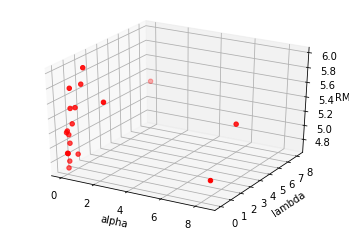

In [52]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_log["alpha"], df_log["lambda"], df_log["FinalObjectiveValue"], c='r', marker='o')

ax.set_xlabel('alpha');
ax.set_ylabel('lambda');
ax.set_zlabel('RMSE');
plt.show()